# Imports e Pré-configuração

In [35]:
import os

os.listdir()

['.config', 'README.md', 'coffee_beans_dataset', 'coffe.zip', 'sample_data']

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.color import rgb2gray

from skimage.feature import graycomatrix, graycoprops

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("Arquivo encontrado?:", os.path.exists(zip_path))

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("coffee_beans_dataset")

sns.set(style="whitegrid")

print("\nExtração concluída!")

print("\nConteúdo da pasta extraída:")
print(os.listdir("coffee_beans_dataset"))

Arquivo encontrado?: True

Extração concluída!

Conteúdo da pasta extraída:
['train', 'valid', 'Coffee Bean.csv', 'test']


# Carregamento do Dataset

In [37]:
import zipfile
import shutil

base_dir = "coffee_beans_dataset"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

if not os.path.exists("coffee.zip"):
    print("Coloque aqui seu arquivo 'coffee.zip'.")
else:
    print("Arquivo encontrado: coffee.zip — Iniciando extração...")
    with zipfile.ZipFile("coffee.zip", "r") as z:
        z.extractall(".")

if os.path.exists("Coffee Bean Dataset"):
    print("Organizando pastas...")
    shutil.move("Coffee Bean Dataset/train", train_dir)
    shutil.move("Coffee Bean Dataset/valid", valid_dir)
    shutil.rmtree("Coffee Bean Dataset", ignore_errors=True)

print("Dataset pronto!")
print("Classes encontradas:", os.listdir(train_dir))

Coloque aqui seu arquivo 'coffee.zip'.
Dataset pronto!
Classes encontradas: ['Light', 'Dark', 'Medium', 'Green']


# Extração de Características (GLCM)

In [38]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_dir = "coffee_beans_dataset/train"

def extract_glcm_features(image):
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)

    glcm = graycomatrix(gray, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return [contrast, dissimilarity, homogeneity]

X_features = []
y_labels = []

class_names = os.listdir(train_dir)
class_names.sort()

print("Classes encontradas:", class_names)

for label_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dir, class_name)

    for file in os.listdir(class_folder):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(class_folder, file)
            img = imread(img_path)
            X_features.append(extract_glcm_features(img))
            y_labels.append(label_index)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print("\nTotal de amostras extraídas:", len(X_features))
print("Formato do vetor de características:", X_features.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("\nTreinamento:", len(X_train))
print("Teste:", len(X_test))


Classes encontradas: ['Dark', 'Green', 'Light', 'Medium']

Total de amostras extraídas: 1200
Formato do vetor de características: (1200, 3)

Treinamento: 960
Teste: 240


# Treinamento e Avaliação k-NN


--- RESULTADOS (GLCM + k-NN) ---
Acurácia:       0.5875
Precisão:       0.5930
Recall:         0.5875
F1-score:       0.5885


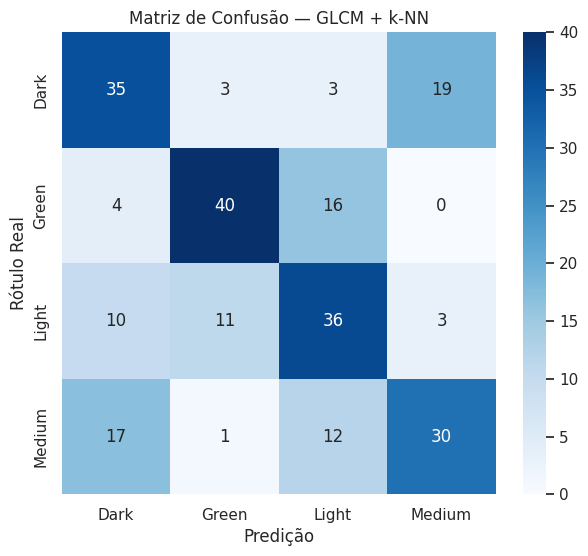

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

cm = confusion_matrix(y_test, y_pred)

print("\n--- RESULTADOS (GLCM + k-NN) ---")
print(f"Acurácia:       {acuracia:.4f}")
print(f"Precisão:       {precisao:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-score:       {f1:.4f}")

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão — GLCM + k-NN")
plt.xlabel("Predição")
plt.ylabel("Rótulo Real")
plt.show()

# Construção da CNN (EfficientNetB0 + Fine-tuning)

In [40]:
import os
import shutil
from sklearn.model_selection import train_test_split

source = "coffee_beans_dataset/train"
dest_train = "coffee_beans_dataset/train"
dest_valid = "coffee_beans_dataset/valid"

classes = os.listdir(source)


In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    "coffee_beans_dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    "coffee_beans_dataset/valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

class_indices = train_generator.class_indices
class_indices

Found 1200 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

# Treinamento CNN

In [42]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,113,825 (15.69 MB)

 Trainable params: 4,071,802 (15.53 MB)

 Non-trainable params: 42,023 (164.16 KB)

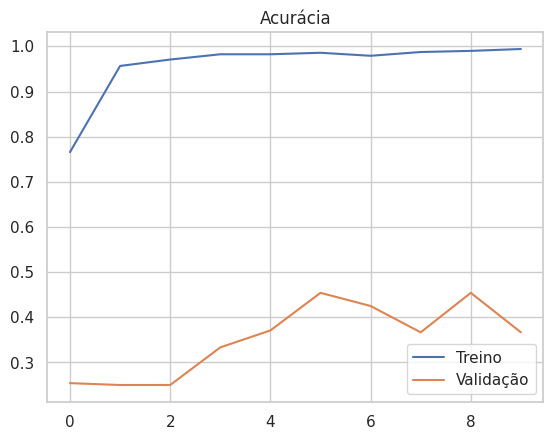

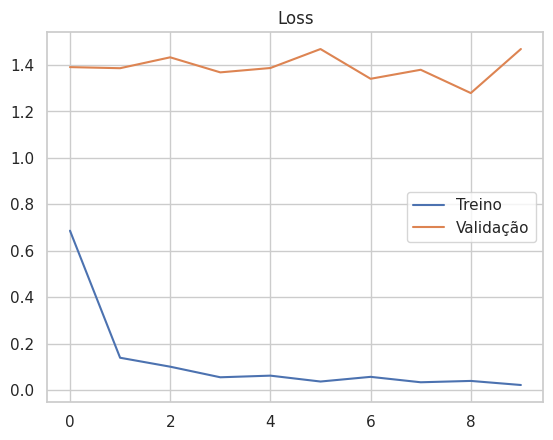

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia')
plt.legend(['Treino','Validação'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Treino','Validação'])
plt.show()


# Avaliação CNN

In [44]:
cands = ['valid_generator', 'valid_gen', 'valid_set', 'val_generator', 'valid_generator']
valid_var = None
for name in cands:
    if name in globals():
        valid_var = globals()[name]
        print(f"Usando gerador de validação: {name}")
        break

train_cands = ['train_generator', 'train_gen', 'train_set', 'train_set']
train_var = None
for name in train_cands:
    if name in globals():
        train_var = globals()[name]
        print(f"Usando gerador de treino: {name}")
        break

if train_var is None or valid_var is None:
    raise RuntimeError("Não encontrou geradores de treino/validação no ambiente. Verifique nomes (ex.: train_gen, valid_gen, train_set, valid_set).")

history = model.fit(
    train_var,
    validation_data=valid_var,
    epochs=10
)


Usando gerador de validação: valid_generator
Usando gerador de treino: train_generator


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 345ms/step - accuracy: 0.6015 - loss: 0.9993 - val_accuracy: 0.2542 - val_loss: 1.3909
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.9547 - loss: 0.1507 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.9684 - loss: 0.1131 - val_accuracy: 0.2500 - val_loss: 1.4331
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.9896 - loss: 0.0507 - val_accuracy: 0.3333 - val_loss: 1.3683
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.9767 - loss: 0.0624 - val_accuracy: 0.3708 - val_loss: 1.3871
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9897 - loss: 0.0349 - val_accuracy: 0.4542 - val_loss: 1.4687
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.9823 - loss: 0.0520 - val_accuracy: 0.4250 - val_loss: 1.3406
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.9891 - loss: 0.0330 - val_accu